# Análisis Estadístico de Tiempos de Respuesta 📊⏱️

Este notebook realiza análisis estadísticos sobre los tiempos de respuesta de los diferentes agentes, incluyendo pruebas de hipótesis y análisis de varianza.

In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway, ttest_ind, mannwhitneyu, kruskal
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## 1. Carga y Exploración Inicial de Datos

In [14]:
# Cargar datos
with open('results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f"📊 Total de observaciones: {len(df)}")
print(f"🔄 Agentes únicos: {df['agent'].nunique()}")
print(f"📈 Niveles de dificultad: {df['difficulty'].nunique()}")
print("\n📋 Estadísticas descriptivas del tiempo de respuesta:")
print(df['response_time'].describe())

df.head()

📊 Total de observaciones: 30
🔄 Agentes únicos: 4
📈 Niveles de dificultad: 4

📋 Estadísticas descriptivas del tiempo de respuesta:
count    30.000000
mean      3.953563
std       2.335354
min       0.000574
25%       2.161199
50%       3.850856
75%       5.350637
max       9.300506
Name: response_time, dtype: float64


,id,consulta,agent,difficulty,category,response_time
0,SUP_001,¿Qué es el teorema de Pitágoras?,math_expert,fácil,definicion,5.355249
1,SUP_002,Crea un examen sobre álgebra básica,exam_creator,fácil,crear_examen,2.369845
2,SUP_003,Haz un plan de estudio para matemáticas,planning,fácil,planificacion,3.754303
3,SUP_004,¿Está bien explicado?,evaluator,medio,evaluacion,1.750592
4,SUP_005,No entiendo cómo resolver ecuaciones cuadráticas,math_expert,medio,explicacion,7.016694


## 2. Análisis Exploratorio de Datos (EDA)

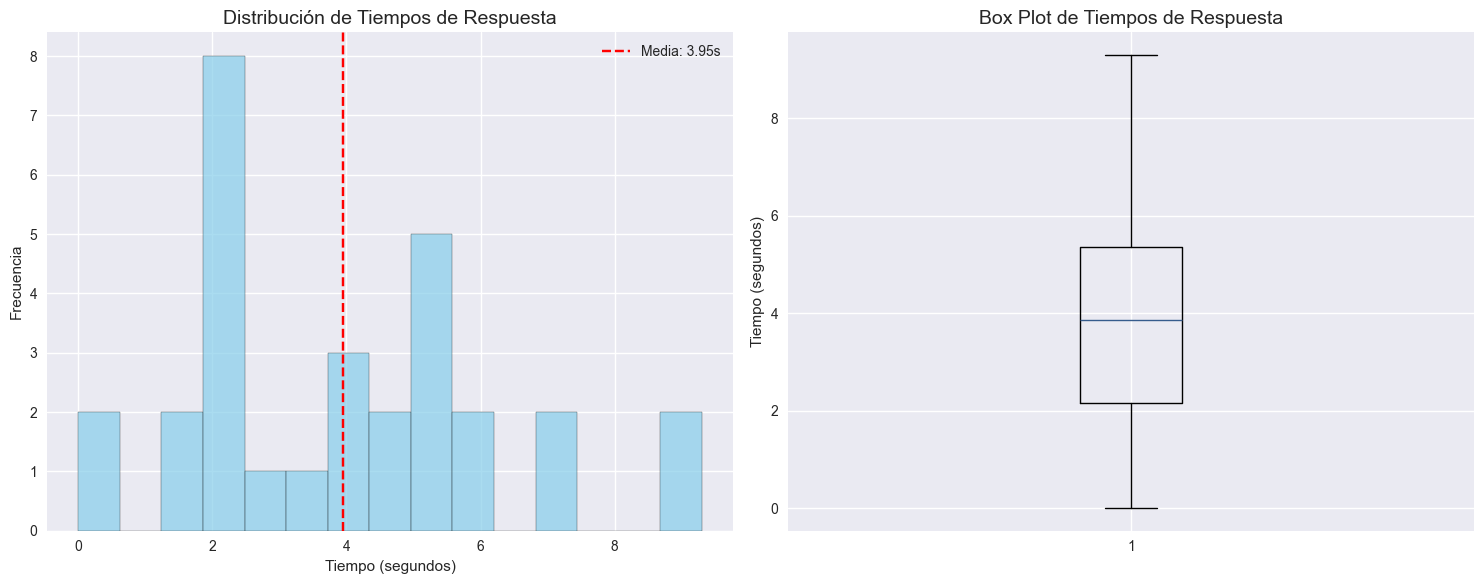


🚨 Outliers detectados: 0


In [15]:
# Distribución general de tiempos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma
axes[0].hist(df['response_time'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Tiempos de Respuesta', fontsize=14)
axes[0].set_xlabel('Tiempo (segundos)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df['response_time'].mean(), color='red', linestyle='--', 
                label=f'Media: {df["response_time"].mean():.2f}s')
axes[0].legend()

# Box plot
axes[1].boxplot(df['response_time'])
axes[1].set_title('Box Plot de Tiempos de Respuesta', fontsize=14)
axes[1].set_ylabel('Tiempo (segundos)')

plt.tight_layout()
plt.show()

# Identificar outliers
Q1 = df['response_time'].quantile(0.25)
Q3 = df['response_time'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['response_time'] < Q1 - 1.5*IQR) | (df['response_time'] > Q3 + 1.5*IQR)]
print(f"\n🚨 Outliers detectados: {len(outliers)}")
if len(outliers) > 0:
    print(outliers[['id', 'consulta', 'agent', 'response_time']])

## 3. Análisis por Agente

📊 Estadísticas por Agente:


,count,mean,median,std,min,max
agent,,,,,,
evaluator,6,1.255,1.711,0.986,0.001,2.136
exam_creator,7,2.291,2.272,0.321,1.868,2.906
math_expert,11,6.267,5.685,1.655,4.189,9.301
planning,6,4.350,4.155,0.702,3.646,5.301


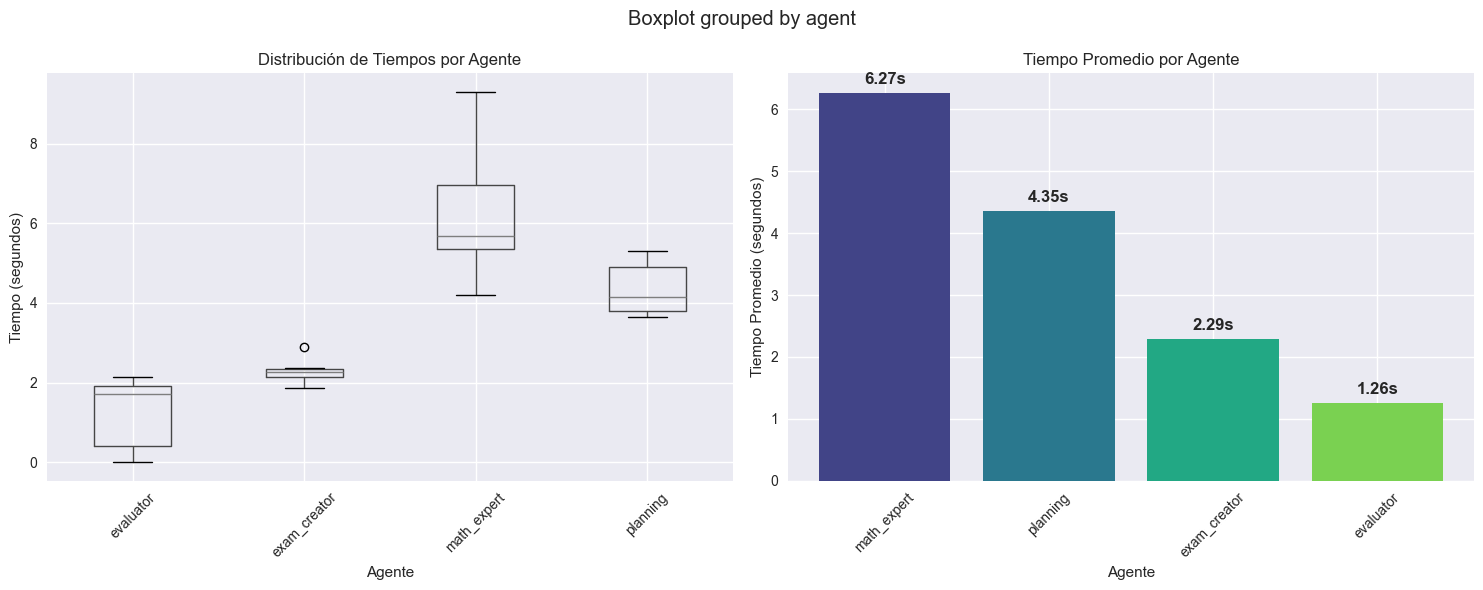

In [16]:
# Estadísticas por agente
agent_stats = df.groupby('agent')['response_time'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)

print("📊 Estadísticas por Agente:")
display(agent_stats)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot por agente
df.boxplot(column='response_time', by='agent', ax=axes[0])
axes[0].set_title('Distribución de Tiempos por Agente')
axes[0].set_xlabel('Agente')
axes[0].set_ylabel('Tiempo (segundos)')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Bar plot de medias
agent_means = df.groupby('agent')['response_time'].mean().sort_values(ascending=False)
bars = axes[1].bar(agent_means.index, agent_means.values, 
                   color=sns.color_palette("viridis", len(agent_means)))
axes[1].set_title('Tiempo Promedio por Agente')
axes[1].set_xlabel('Agente')
axes[1].set_ylabel('Tiempo Promedio (segundos)')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Análisis por Dificultad

📊 Estadísticas por Dificultad:


,count,mean,median,std,min,max
difficulty,,,,,,
ambiguo,7,4.716,5.090,2.399,1.973,9.055
difícil,6,3.639,2.809,3.826,0.001,9.301
fácil,6,3.472,3.062,1.360,2.272,5.355
medio,11,3.903,3.646,1.874,1.751,7.017


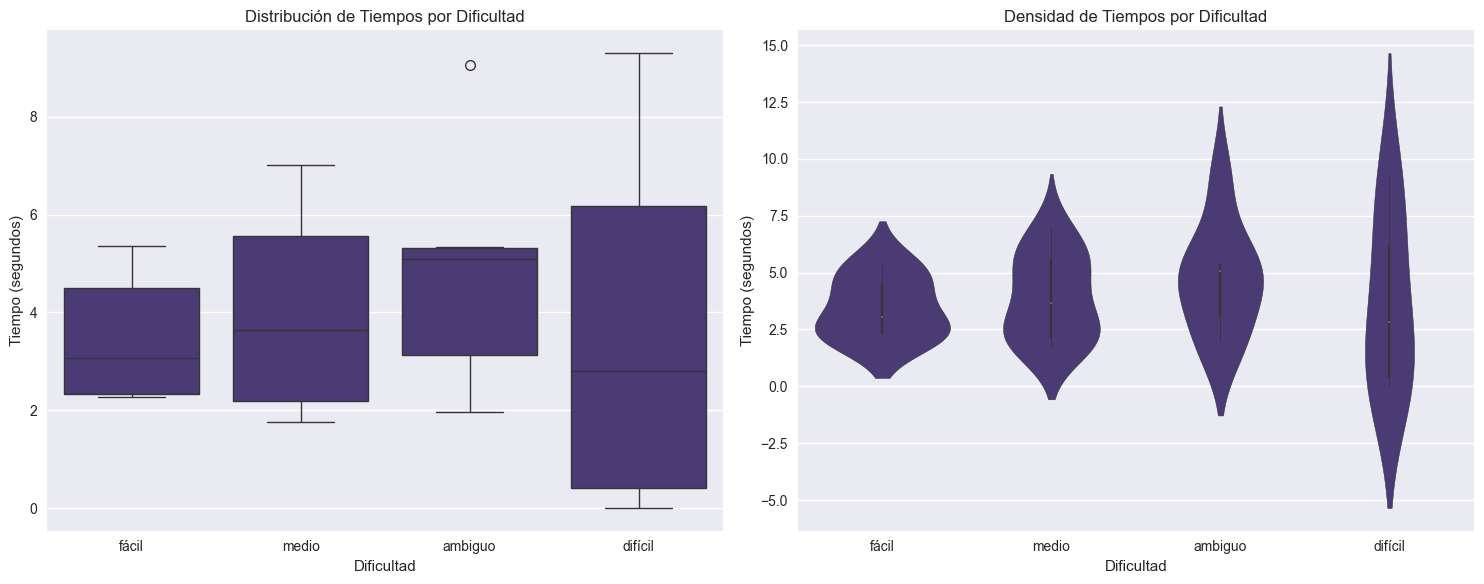

In [17]:
# Estadísticas por dificultad
difficulty_stats = df.groupby('difficulty')['response_time'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)

print("📊 Estadísticas por Dificultad:")
display(difficulty_stats)

# Ordenar dificultades
difficulty_order = ['fácil', 'medio', 'ambiguo', 'difícil']
df['difficulty'] = pd.Categorical(df['difficulty'], categories=difficulty_order, ordered=True)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot por dificultad
sns.boxplot(data=df, x='difficulty', y='response_time', ax=axes[0])
axes[0].set_title('Distribución de Tiempos por Dificultad')
axes[0].set_xlabel('Dificultad')
axes[0].set_ylabel('Tiempo (segundos)')

# Violin plot
sns.violinplot(data=df, x='difficulty', y='response_time', ax=axes[1])
axes[1].set_title('Densidad de Tiempos por Dificultad')
axes[1].set_xlabel('Dificultad')
axes[1].set_ylabel('Tiempo (segundos)')

plt.tight_layout()
plt.show()

## 5. Pruebas de Hipótesis

### 5.1. Comparación entre Agentes (ANOVA / Kruskal-Wallis)

In [19]:
agent_groups = [df[df['agent'] == agent]['response_time'].values for agent in df['agent'].unique()]

# Test de homogeneidad de varianzas (Levene)
stat_levene, p_levene = levene(*agent_groups)
print(f"🔍 Test de Levene (Homogeneidad de Varianzas):")
print(f"   p-valor: {p_levene:.4f}")
print(f"   Resultado: {'Varianzas homogéneas' if p_levene > 0.05 else 'Varianzas no homogéneas'} (α = 0.05)")

# Decidir entre ANOVA paramétrico o Kruskal-Wallis no paramétrico
normal_count = sum(1 for result in normality_results.values() if result['normal'])
use_parametric = (normal_count >= len(normality_results) * 0.7) and (p_levene > 0.05)

print(f"\n📊 Análisis elegido: {'ANOVA paramétrico' if use_parametric else 'Kruskal-Wallis no paramétrico'}")

if use_parametric:
    # ANOVA de una vía
    stat_anova, p_anova = f_oneway(*agent_groups)
    print(f"\n🎯 ANOVA de una vía:")
    print(f"   F-estadístico: {stat_anova:.4f}")
    print(f"   p-valor: {p_anova:.4f}")
    print(f"   Resultado: {'Hay diferencias significativas' if p_anova < 0.05 else 'No hay diferencias significativas'} entre agentes (α = 0.05)")
else:
    # Kruskal-Wallis
    stat_kw, p_kw = kruskal(*agent_groups)
    print(f"\n🎯 Test de Kruskal-Wallis:")
    print(f"   H-estadístico: {stat_kw:.4f}")
    print(f"   p-valor: {p_kw:.4f}")
    print(f"   Resultado: {'Hay diferencias significativas' if p_kw < 0.05 else 'No hay diferencias significativas'} entre agentes (α = 0.05)")

🔍 Test de Levene (Homogeneidad de Varianzas):
   p-valor: 0.1513
   Resultado: Varianzas homogéneas (α = 0.05)

📊 Análisis elegido: ANOVA paramétrico

🎯 ANOVA de una vía:
   F-estadístico: 30.1177
   p-valor: 0.0000
   Resultado: Hay diferencias significativas entre agentes (α = 0.05)


### 5.2. Comparaciones Post-hoc (Agentes específicos)

In [20]:
# Comparaciones por pares entre agentes
from itertools import combinations

agents = df['agent'].unique()
print("🔍 Comparaciones por pares entre agentes:")
print("=" * 50)

pairwise_results = []

for agent1, agent2 in combinations(agents, 2):
    group1 = df[df['agent'] == agent1]['response_time']
    group2 = df[df['agent'] == agent2]['response_time']
    
    # Decidir test paramétrico vs no paramétrico
    if use_parametric:
        stat, p_value = ttest_ind(group1, group2)
        test_name = "t-test"
    else:
        stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
        test_name = "Mann-Whitney U"
    
    significant = p_value < 0.05
    mean1, mean2 = group1.mean(), group2.mean()
    
    print(f"{agent1} vs {agent2}:")
    print(f"   Medias: {mean1:.3f}s vs {mean2:.3f}s")
    print(f"   {test_name}: p = {p_value:.4f} {'***' if significant else ''}")
    print(f"   Resultado: {'Diferencia significativa' if significant else 'Sin diferencia significativa'}")
    print()
    
    pairwise_results.append({
        'comparison': f"{agent1} vs {agent2}",
        'mean1': mean1,
        'mean2': mean2,
        'p_value': p_value,
        'significant': significant
    })

# Crear DataFrame de resultados
pairwise_df = pd.DataFrame(pairwise_results)
print("📋 Resumen de comparaciones:")
display(pairwise_df)

🔍 Comparaciones por pares entre agentes:
math_expert vs exam_creator:
   Medias: 6.267s vs 2.291s
   t-test: p = 0.0000 ***
   Resultado: Diferencia significativa

math_expert vs planning:
   Medias: 6.267s vs 4.350s
   t-test: p = 0.0173 ***
   Resultado: Diferencia significativa

math_expert vs evaluator:
   Medias: 6.267s vs 1.255s
   t-test: p = 0.0000 ***
   Resultado: Diferencia significativa

exam_creator vs planning:
   Medias: 2.291s vs 4.350s
   t-test: p = 0.0000 ***
   Resultado: Diferencia significativa

exam_creator vs evaluator:
   Medias: 2.291s vs 1.255s
   t-test: p = 0.0230 ***
   Resultado: Diferencia significativa

planning vs evaluator:
   Medias: 4.350s vs 1.255s
   t-test: p = 0.0001 ***
   Resultado: Diferencia significativa

📋 Resumen de comparaciones:


,comparison,mean1,mean2,p_value,significant
0,math_expert vs exam_creator,6.266699,2.291484,0.000012,True
1,math_expert vs planning,6.266699,4.350123,0.017261,True
2,math_expert vs evaluator,6.266699,1.255347,0.000007,True
3,exam_creator vs planning,2.291484,4.350123,0.000023,True
4,exam_creator vs evaluator,2.291484,1.255347,0.023007,True
5,planning vs evaluator,4.350123,1.255347,0.000093,True


### 5.3. Análisis por Dificultad

In [21]:
# Comparación por niveles de dificultad
difficulty_groups = [df[df['difficulty'] == diff]['response_time'].values 
                    for diff in df['difficulty'].unique() if len(df[df['difficulty'] == diff]) > 0]

if len(difficulty_groups) > 1:
    # Test de Kruskal-Wallis para dificultad
    stat_diff, p_diff = kruskal(*difficulty_groups)
    print(f"🎯 Test de Kruskal-Wallis (Dificultad):")
    print(f"   H-estadístico: {stat_diff:.4f}")
    print(f"   p-valor: {p_diff:.4f}")
    print(f"   Resultado: {'Hay diferencias significativas' if p_diff < 0.05 else 'No hay diferencias significativas'} entre niveles de dificultad")
    
    # Análisis de correlación ordinal
    difficulty_mapping = {'fácil': 1, 'medio': 2, 'ambiguo': 3, 'difícil': 4}
    df['difficulty_numeric'] = df['difficulty'].map(difficulty_mapping)
    
    correlation, p_corr = stats.spearmanr(df['difficulty_numeric'], df['response_time'])
    print(f"\n📈 Correlación de Spearman (Dificultad vs Tiempo):")
    print(f"   Coeficiente: {correlation:.4f}")
    print(f"   p-valor: {p_corr:.4f}")
    print(f"   Interpretación: {'Correlación significativa' if p_corr < 0.05 else 'Sin correlación significativa'}")
    
    if correlation > 0:
        print(f"   Tendencia: A mayor dificultad, mayor tiempo de respuesta")
    elif correlation < 0:
        print(f"   Tendencia: A mayor dificultad, menor tiempo de respuesta")
    else:
        print(f"   Tendencia: Sin relación clara")

🎯 Test de Kruskal-Wallis (Dificultad):
   H-estadístico: 0.7912
   p-valor: 0.8516
   Resultado: No hay diferencias significativas entre niveles de dificultad

📈 Correlación de Spearman (Dificultad vs Tiempo):
   Coeficiente: -0.0324
   p-valor: 0.8650
   Interpretación: Sin correlación significativa
   Tendencia: A mayor dificultad, menor tiempo de respuesta


##  6. Intervalos de Confianza

📊 Intervalos de Confianza (95%) por Agente:
math_expert:
   Media: 6.267s
   IC 95%: [5.155s, 7.379s]
   Ancho del IC: 2.224s

exam_creator:
   Media: 2.291s
   IC 95%: [1.995s, 2.588s]
   Ancho del IC: 0.594s

planning:
   Media: 4.350s
   IC 95%: [3.613s, 5.087s]
   Ancho del IC: 1.474s

evaluator:
   Media: 1.255s
   IC 95%: [0.221s, 2.290s]
   Ancho del IC: 2.069s



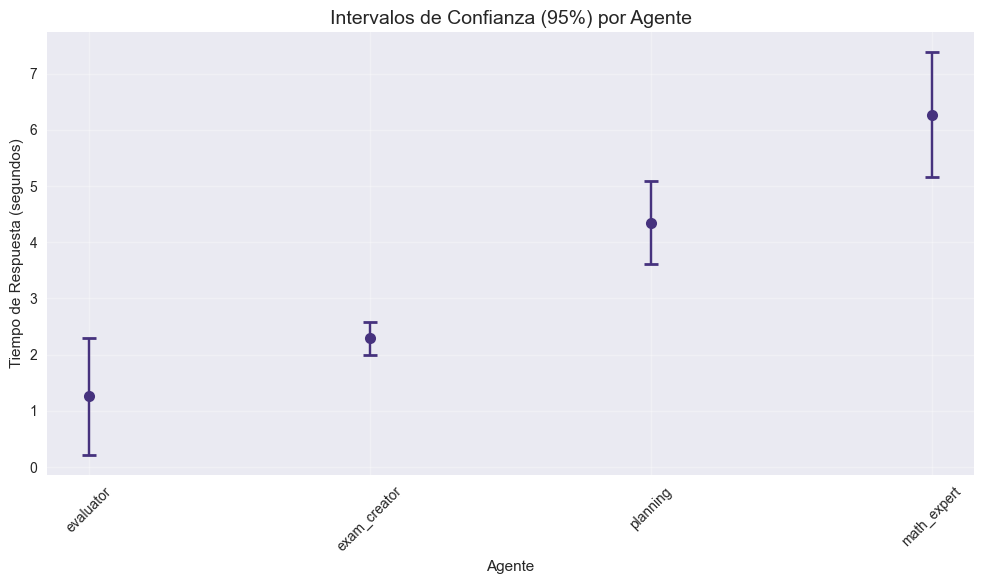

In [22]:
from scipy.stats import t

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return mean - h, mean + h

print("📊 Intervalos de Confianza (95%) por Agente:")
print("=" * 50)

ci_results = []
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]['response_time']
    mean = agent_data.mean()
    ci_lower, ci_upper = confidence_interval(agent_data)
    
    print(f"{agent}:")
    print(f"   Media: {mean:.3f}s")
    print(f"   IC 95%: [{ci_lower:.3f}s, {ci_upper:.3f}s]")
    print(f"   Ancho del IC: {ci_upper - ci_lower:.3f}s")
    print()
    
    ci_results.append({
        'agent': agent,
        'mean': mean,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'ci_width': ci_upper - ci_lower
    })

# Visualización de intervalos de confianza
ci_df = pd.DataFrame(ci_results)
fig, ax = plt.subplots(figsize=(10, 6))

# Ordenar por media
ci_df = ci_df.sort_values('mean')

# Plot
ax.errorbar(ci_df['agent'], ci_df['mean'], 
           yerr=[ci_df['mean'] - ci_df['ci_lower'], ci_df['ci_upper'] - ci_df['mean']],
           fmt='o', capsize=5, capthick=2, markersize=8)

ax.set_title('Intervalos de Confianza (95%) por Agente', fontsize=14)
ax.set_xlabel('Agente')
ax.set_ylabel('Tiempo de Respuesta (segundos)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Resumen de Resultados y Conclusiones

In [23]:
# Resumen estadístico final
print("📋 RESUMEN DE ANÁLISIS ESTADÍSTICO")
print("=" * 60)

print(f"\n🔢 ESTADÍSTICAS GENERALES:")
print(f"   • Total de observaciones: {len(df)}")
print(f"   • Tiempo promedio global: {df['response_time'].mean():.3f}s")
print(f"   • Desviación estándar: {df['response_time'].std():.3f}s")
print(f"   • Rango: {df['response_time'].min():.3f}s - {df['response_time'].max():.3f}s")

print(f"\n🤖 RENDIMIENTO POR AGENTE:")
agent_summary = df.groupby('agent')['response_time'].agg(['mean', 'std', 'count']).round(3)
agent_summary = agent_summary.sort_values('mean')
for idx, row in agent_summary.iterrows():
    print(f"   • {idx}: {row['mean']:.3f}s ± {row['std']:.3f}s (n={int(row['count'])})")

print(f"\n📊 PRUEBAS DE HIPÓTESIS:")
print(f"   • Homogeneidad varianzas: {'✓ Homogéneas' if p_levene > 0.05 else '✗ No homogéneas'} (p={p_levene:.4f})")

if use_parametric:
    print(f"   • ANOVA: {'✓ Diferencias significativas' if p_anova < 0.05 else '✗ Sin diferencias'} (p={p_anova:.4f})")
else:
    print(f"   • Kruskal-Wallis: {'✓ Diferencias significativas' if p_kw < 0.05 else '✗ Sin diferencias'} (p={p_kw:.4f})")

if 'p_diff' in locals():
    print(f"   • Dificultad: {'✓ Diferencias significativas' if p_diff < 0.05 else '✗ Sin diferencias'} (p={p_diff:.4f})")
    if 'correlation' in locals():
        print(f"   • Correlación dificultad-tiempo: {correlation:.3f} ({'significativa' if p_corr < 0.05 else 'no significativa'})")

print(f"\n🎯 COMPARACIONES SIGNIFICATIVAS:")
significant_pairs = [result for result in pairwise_results if result['significant']]
if significant_pairs:
    for pair in significant_pairs:
        print(f"   • {pair['comparison']}: p={pair['p_value']:.4f}")
else:
    print(f"   • No se encontraron diferencias significativas entre agentes")

print(f"\n🔍 CONCLUSIONES:")
fastest_agent = agent_summary.index[0]
slowest_agent = agent_summary.index[-1]
print(f"   • Agente más rápido: {fastest_agent} ({agent_summary.loc[fastest_agent, 'mean']:.3f}s)")
print(f"   • Agente más lento: {slowest_agent} ({agent_summary.loc[slowest_agent, 'mean']:.3f}s)")

# Calcular efecto del tamaño si hay diferencias significativas
if (use_parametric and p_anova < 0.05) or (not use_parametric and p_kw < 0.05):
    # Eta cuadrado como medida del tamaño del efecto
    ss_between = sum(len(group) * (np.mean(group) - df['response_time'].mean())**2 for group in agent_groups)
    ss_total = sum((df['response_time'] - df['response_time'].mean())**2)
    eta_squared = ss_between / ss_total
    print(f"   • Tamaño del efecto (η²): {eta_squared:.3f} ({'Pequeño' if eta_squared < 0.06 else 'Mediano' if eta_squared < 0.14 else 'Grande'})")

if len(outliers) > 0:
    print(f"   • Se detectaron {len(outliers)} outliers que podrían requerir investigación")

print(f"\n⚠️  RECOMENDACIONES:")
if df['response_time'].std() / df['response_time'].mean() > 0.5:
    print(f"   • Alta variabilidad en tiempos - considerar optimización")
if len(significant_pairs) > 0:
    print(f"   • Investigar diferencias entre agentes para optimización")
if len(outliers) > 0:
    print(f"   • Revisar casos outliers para identificar problemas de rendimiento")

📋 RESUMEN DE ANÁLISIS ESTADÍSTICO

🔢 ESTADÍSTICAS GENERALES:
   • Total de observaciones: 30
   • Tiempo promedio global: 3.954s
   • Desviación estándar: 2.335s
   • Rango: 0.001s - 9.301s

🤖 RENDIMIENTO POR AGENTE:
   • evaluator: 1.255s ± 0.986s (n=6)
   • exam_creator: 2.291s ± 0.321s (n=7)
   • planning: 4.350s ± 0.702s (n=6)
   • math_expert: 6.267s ± 1.655s (n=11)

📊 PRUEBAS DE HIPÓTESIS:
   • Normalidad global: ✓ Normal (p=0.2040)
   • Homogeneidad varianzas: ✓ Homogéneas (p=0.1513)
   • ANOVA: ✓ Diferencias significativas (p=0.0000)
   • Dificultad: ✗ Sin diferencias (p=0.8516)
   • Correlación dificultad-tiempo: -0.032 (no significativa)

🎯 COMPARACIONES SIGNIFICATIVAS:
   • math_expert vs exam_creator: p=0.0000
   • math_expert vs planning: p=0.0173
   • math_expert vs evaluator: p=0.0000
   • exam_creator vs planning: p=0.0000
   • exam_creator vs evaluator: p=0.0230
   • planning vs evaluator: p=0.0001

🔍 CONCLUSIONES:
   • Agente más rápido: evaluator (1.255s)
   • Agente